## Librerias

In [32]:
from random import random
import generators as gen
from math import log, sin, pi
import numpy as np
import matplotlib.pyplot as plt


## Funciones Auxiliares

In [82]:
generator = gen.Mersenne(1)

def lamda_t(t):
    return 30 + 30 * np.sin((2 * np.pi * t) / 24)
    
def Poisson_NH(T):
    NT = 0
    Eventos = []
    lamda = 60
    t = -log(1 - next(generator)) / lamda
    while t <= T:
        V = next(generator)
        if V < lamda_t(t) / lamda:
            NT += 1
            Eventos.append(t)
        t += -log(1 - next(generator)) / lamda
    return NT, Eventos

def exp(lamda):
    u =  next(generator)
    return -log(u)/lamda

In [34]:
"""
Graficamos para visualizar nuestra funcion lamda
"""
def lamda(x):
    x = np.asarray(x, dtype = float)
    return np.piecewise(
        x,
        [x < 0, (0 <= x) & (x <= 48), x > 48],
        [0, lambda x: lamda_t(x), 0]
    )
# Generar valores de x
x = np.linspace(0, 48, 1000)

# Crear la figura
plt.figure(figsize=(8, 4))
plt.plot(x, lamda(x), 'b-', linewidth=2)
plt.title(r'$\lambda(t) = 30 + 30\sin\left(\frac{2\pi t}{24}\right)$')
plt.xlabel('t (horas)')
plt.ylabel(r'$\lambda(t)$ (clientes/hora)')
plt.grid(True)

# Guardar el gráfico como imagen
plt.tight_layout()
plt.savefig("lamda_funcion.png", dpi=300)  # Cambia el nombre si querés otro archivo
plt.close()  # Cierra la figura para liberar memoria

## Simulacion del Sistema

In [35]:
def queueSystem(hours=48):
    #Resultados
    n, arribos =  Poisson_NH(hours)
    servicios = [exp(40) for _ in arribos]
    esperas = []
    inactivos = []
    uso = [[0,0]]
    tamaño_cola = [[0,0]]

    #auxiliares
    queue = []
    arriboAnt = 0
    h = 0
    
    for i in range(n):
        #Chequeamos en cada hora el estado de la cola
        while (arribos[i]*100) > (h + 1):
            h += 1
            while len(queue) != 0 and queue[0] < h/100:
                queue.pop(0)   
            tamaño_cola.append([h/100, len(queue)])

        #Calculmos espera de cliente y tiempo inactivo del servidor
        inicio = max(arribos[i], arriboAnt)
        espera = inicio - arribos[i]
        inactivo = inicio - arriboAnt
        esperas.append(espera)
        inactivos.append(inactivo)

        arriboAnt = inicio + servicios[i]

        #calculamo intervalos de uso del servidor continuado
        if espera != 0:
            uso[-1][1] += servicios[i]
            queue.append(inicio)
        else:
            uso.append([inicio, inicio + servicios[i]]) 
                    
    return arribos, servicios, esperas, inactivos, uso, tamaño_cola

arribos, servicios, esperas, inactivos, uso, tamaño_cola = queueSystem()

## Obtencion de Datos

### Tasa de Utilizacion del servicio.

In [36]:
def tasa_servicio(usos, horas=48):
    tasa = [0.0] * horas
    for uso in usos:
        inicio, fin = uso
        h_ini = int(np.floor(inicio))
        h_fin = int(np.floor(fin))
        
        # Asegurar que el servicio solo se considere dentro del rango de horas
        for h in range(max(h_ini, 0), min(h_fin + 1, horas)):
            comienzo = max(inicio, h)
            termino = min(fin, h + 1)
            if termino > comienzo:
                tasa[h] += termino - comienzo
    return tasa

def promedio_tasa(Nsim):
    tasa_est = [0]*48
    for _ in range(Nsim):
        _, _, _, _, uso, _ = queueSystem()
        tasa = tasa_servicio(uso)
        for i in range(48):
            tasa_est[i] += tasa[i]
            
    for i in range(48):
        tasa_est[i] = tasa_est[i] / Nsim 
    return tasa_est

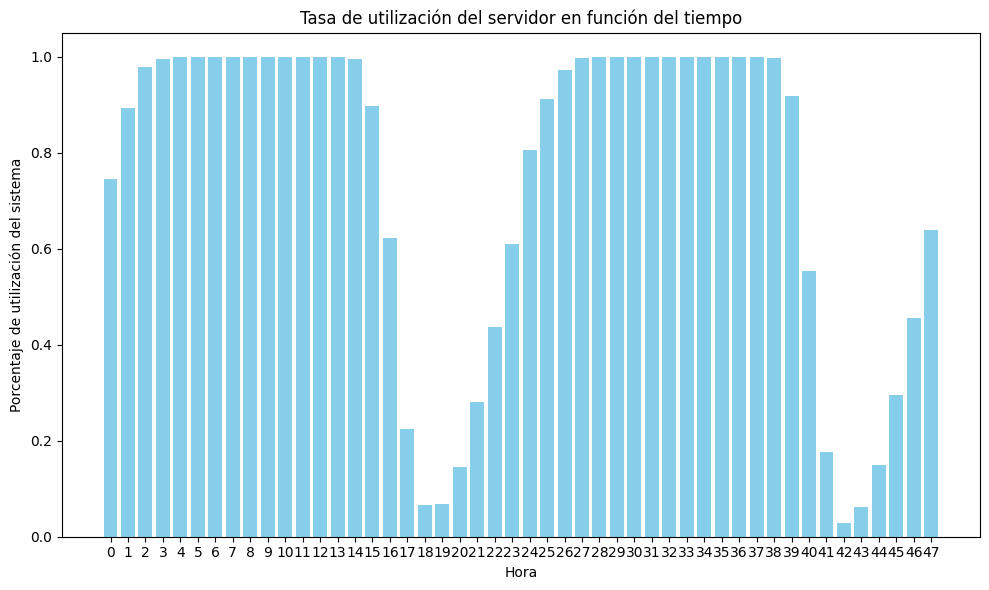

In [37]:
tasa = np.array(promedio_tasa(100))
horas = np.arange(48)
plt.figure(figsize=(10, 6))
plt.bar(horas, tasa, color='skyblue')
plt.title('Tasa de utilización del servidor en función del tiempo')
plt.xlabel('Hora')
plt.ylabel('Porcentaje de utilización del sistema')
plt.xticks(horas)  # Opcional: muestra todos los ticks de hora
plt.tight_layout()

# Guardar el gráfico como imagen
plt.tight_layout()
plt.savefig("tasa.png", dpi=300)  # Cambia el nombre si querés otro archivo
plt.show()
plt.close()  # Cierra la figura para liberar memoria


### Porcentaje de tiempo del servido ocupado


In [56]:
def promedio_uso(Nsim):
    r = 0
    for _ in range(Nsim):
        _, _, _, _, uso, _ = queueSystem()
        tasa = tasa_servicio(uso)
        procentaje = float(np.mean(tasa))

        r += procentaje
    return r / Nsim

promedio_uso(1000)

0.7484374319191436

### Tiempo promedio de cliente en sistema

In [72]:
def est_mean(Nsim): 
    D_acu = 0
    n_acu = 0
    for _ in range(Nsim):
        _, servicios, esperas, _, _, _ = queueSystem()
        n_acu =+ len(servicios)
        D_acu =+ sum(servicios) + sum(esperas)
    return (D_acu / Nsim) / (n_acu / Nsim)

est_mean(12000)

1.6423253649474683

### Evolucion de la Cola

In [44]:
arribos, servicios, esperas, inactivos, uso, cola = queueSystem()

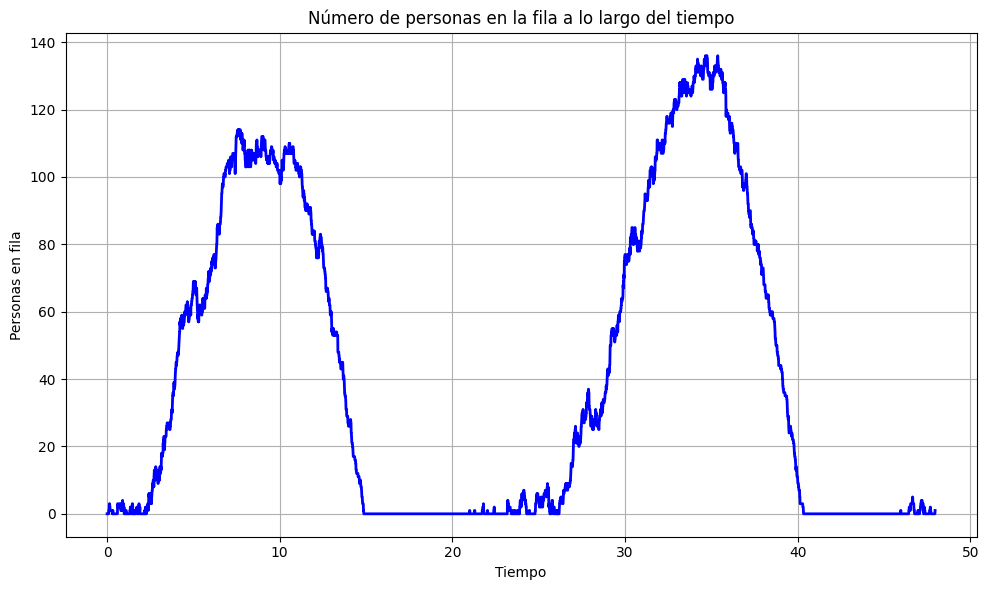

In [45]:
cola = np.array(cola)
tiempos = cola[:, 0]
personas_en_fila = cola[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(tiempos, personas_en_fila, 'b-', linewidth=2)
plt.title('Número de personas en la fila a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Personas en fila')
plt.grid(True)

# Guardar el gráfico como imagen
plt.tight_layout()
plt.savefig("cola.png", dpi=300)  # Cambia el nombre si querés otro archivo
plt.show()
plt.close()  # Cierra la figura para liberar memoria


In [46]:
""" Función para graficar la CDF usando la función ecdf definida anteriormente sólo para comparar """
def ecdf(datos, N):
    datos = sorted(datos) 
    n = len(datos)
    x = np.linspace(min(datos), max(datos), N)
    y = np.zeros(N)
    
    for i in range(N):
        y[i] = sum(1 for d in datos if d <= x[i]) / n
    
    return x, y

def ecdf_ajustada(datos, ajuste,  N):
    datos = sorted(datos) 
    n = len(datos)
    x = np.linspace(min(datos), ajuste, N)
    y = np.zeros(N)
    
    for i in range(N):
        y[i] = sum(1 for d in datos if d <= x[i]) / n
    
    return x, y

def plot_cdf2(data, title, xlabel, ylabel, name):
    x, y = ecdf(data, 1000)
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='.', linestyle='none')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    # Guardar el gráfico como imagen
    plt.tight_layout()
    plt.savefig(f"cdf_{name}.png", dpi=300)  # Cambia el nombre si querés otro archivo
    plt.show()
    plt.close()  # Cierra la figura para liberar memoria

def plot_cdf2_ajuste(data, ajuste, title, xlabel, ylabel, name):
    x, y = ecdf_ajustada(data, ajuste, 1000)
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='.', linestyle='none')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    # Guardar el gráfico como imagen
    plt.tight_layout()
    plt.savefig(f"cdf_ajuste_{name}.png", dpi=300)  # Cambia el nombre si querés otro archivo
    plt.show()
    plt.close()  # Cierra la figura para liberar memoria

def plot_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, color='lightgreen', edgecolor='black', density=True)  # `density=True` normaliza
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    
    # Guardar como imagen
    plt.tight_layout()
    plt.savefig("histograma_esperas.png", dpi=300)
    plt.show()
    plt.close()

### Distribucion de tiempos entre  arribos

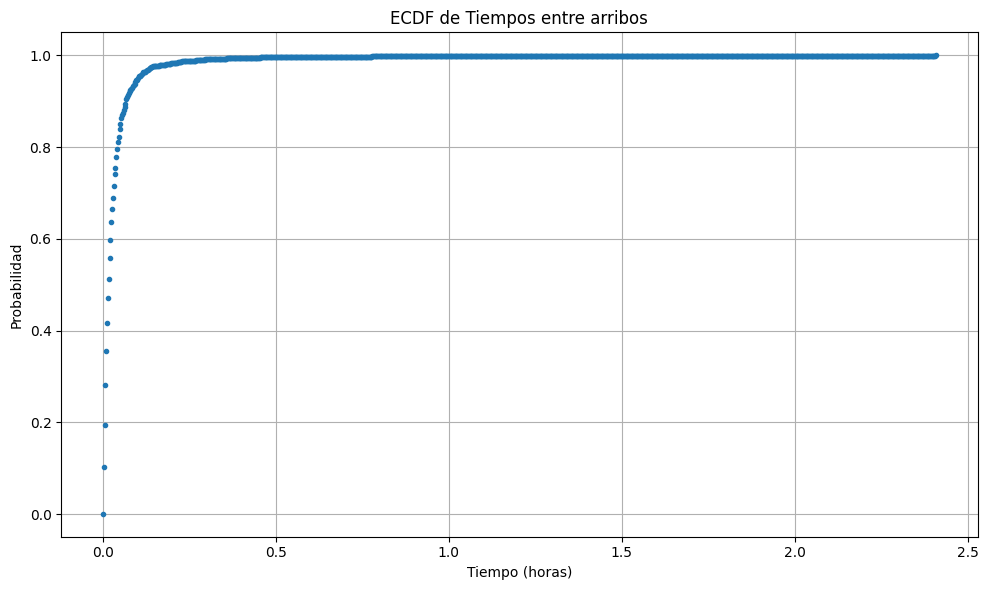

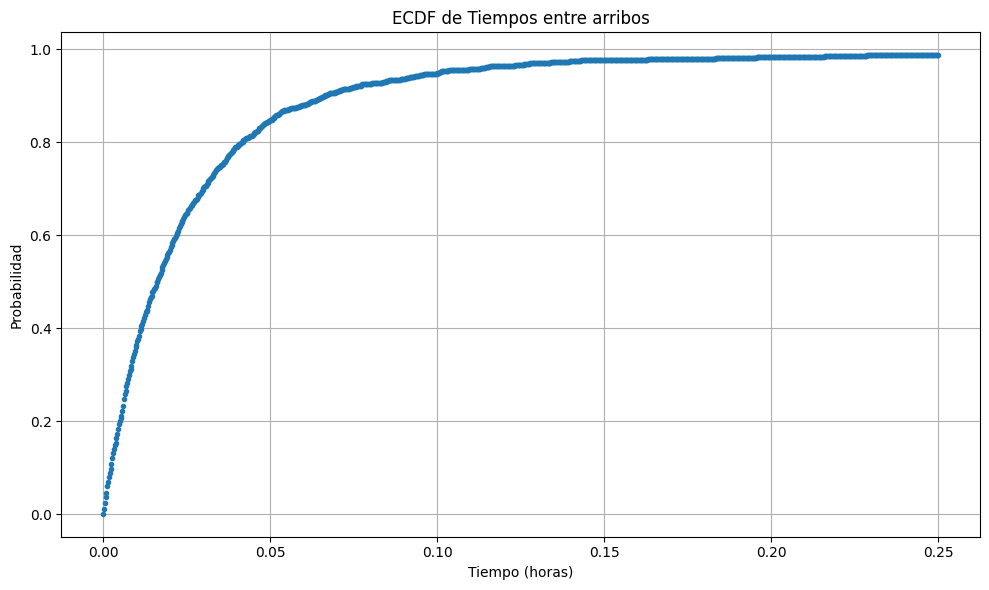

In [47]:
def entre_arribos(arribos):
    entre_arribos = [0] * (len(arribos) - 1)
    for i in range(len(arribos)-1):
        entre_arribos[i] = arribos[i+1] - arribos[i]
    return entre_arribos

entre_arribos = entre_arribos(arribos)
plot_cdf2(entre_arribos, 'ECDF de Tiempos entre arribos', 'Tiempo (horas)', 'Probabilidad', "entre_arribos")
plot_cdf2_ajuste(entre_arribos, 0.25, 'ECDF de Tiempos entre arribos', 'Tiempo (horas)', 'Probabilidad', "entre_arribos")

### Distribucion entre los servicios

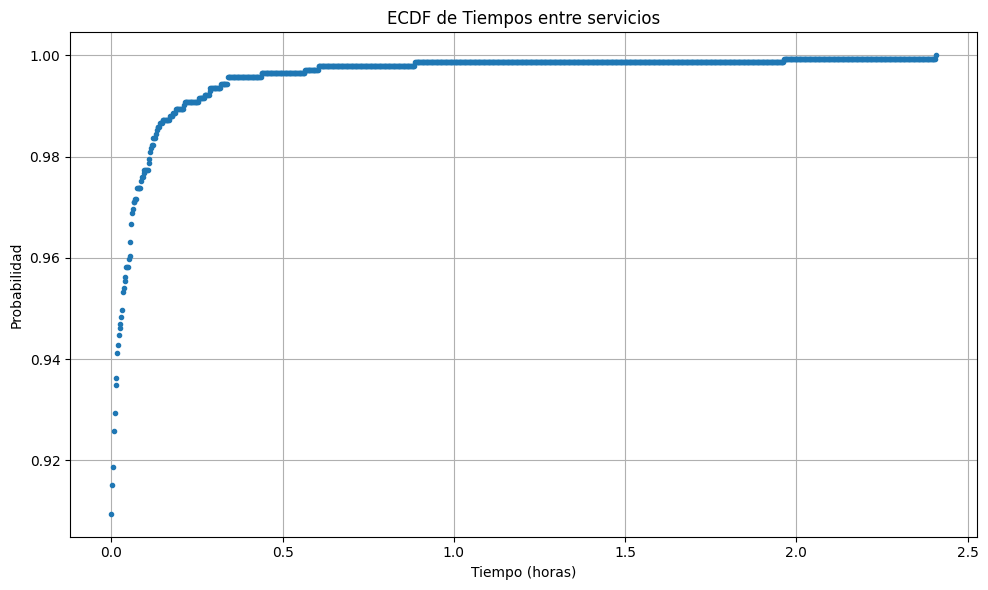

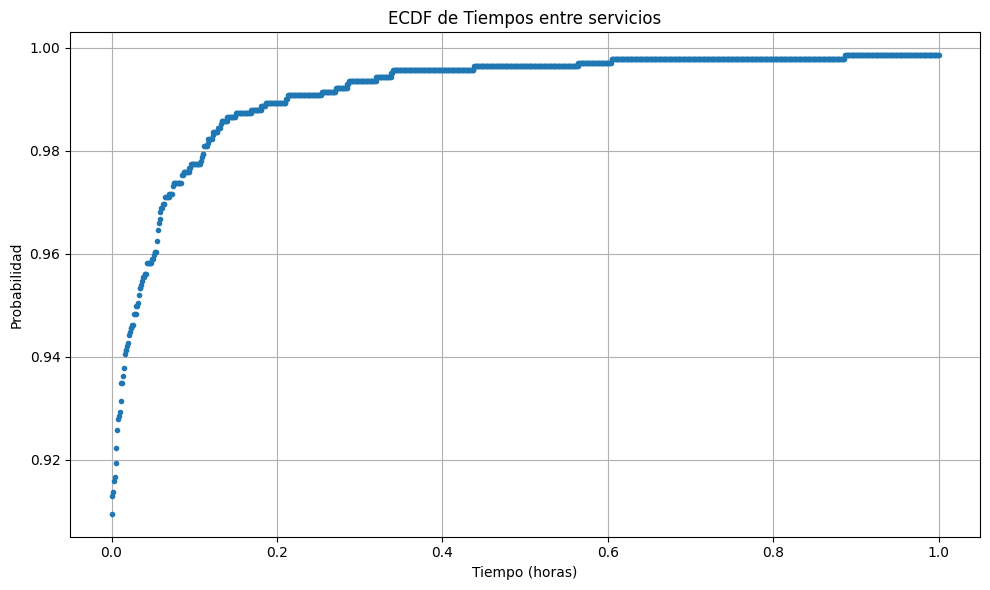

In [48]:
plot_cdf2(inactivos, 'ECDF de Tiempos entre servicios', 'Tiempo (horas)', 'Probabilidad', "entre_servicios")
plot_cdf2_ajuste(inactivos, 1, 'ECDF de Tiempos entre servicios', 'Tiempo (horas)', 'Probabilidad', "entre_servicios")

### Distribucion de Tiempos de espera

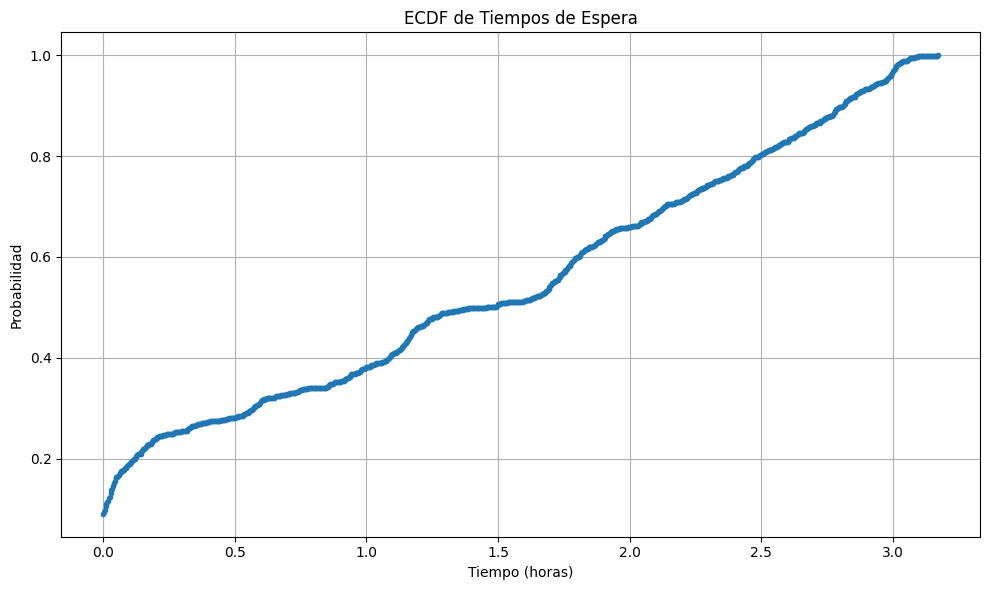

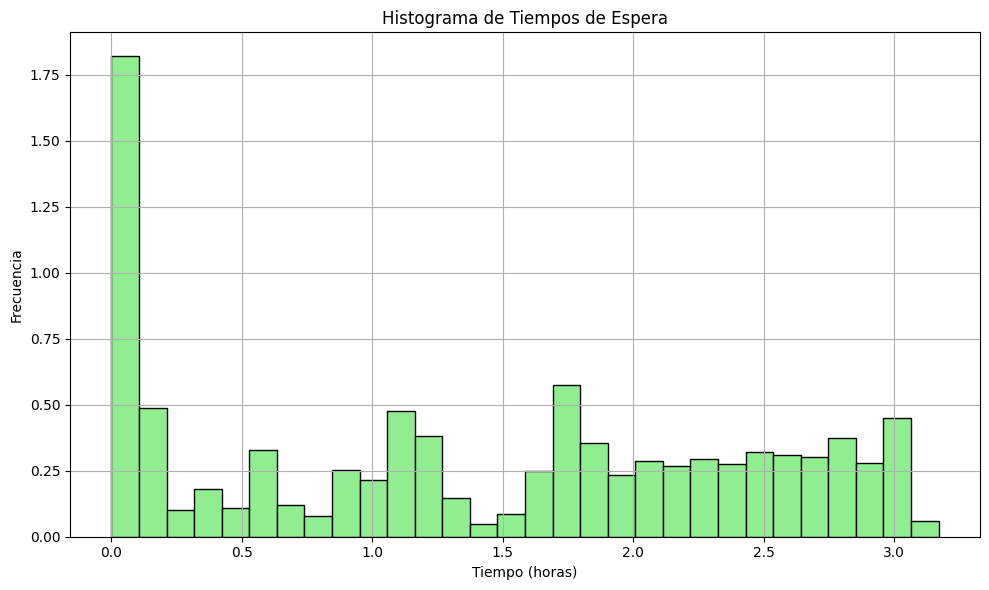

In [49]:
"""Se utiliza statsmodels para graficar la CDF de los tiempos de espera
def plot_cdf(data, title, xlabel, ylabel):
    x, y = ECDF(data).x, ECDF(data).y
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='.', linestyle='none')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
""" 

# Graficar histogramas y CDFs
plot_cdf2(esperas, 'ECDF de Tiempos de Espera', 'Tiempo (horas)', 'Probabilidad', "esperas")
plot_histogram(esperas, 'Histograma de Tiempos de Espera', 'Tiempo (horas)', 'Frecuencia')

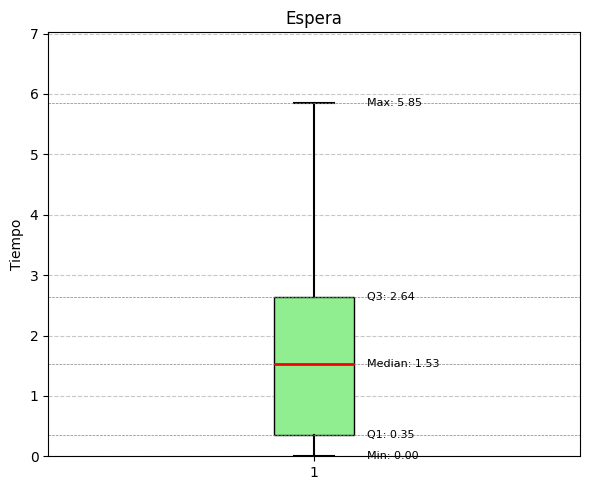

In [83]:
#Grafocar boxĺot de las espera
def box_plot(Nsim):
    data = []
    for _ in range(Nsim):
        _, _, esperas, _, _, _ = queueSystem()
        data +=  esperas

    fig, ax = plt.subplots(figsize=(6, 5))

    # Dibujar boxplot
    bp = ax.boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen', color='black'),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='o', color='orange', markersize=6, linestyle='none',
                                    markerfacecolor='orange'))

    # Títulos y etiquetas
    ax.set_title("Espera")
    ax.set_ylabel("Tiempo")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Limitar el eje Y para mejorar visualización de valores pequeños
    ax.set_ylim(0, max(data) * 1.2)

    # Agregar anotaciones estadísticas
    stats = {
        "Min": np.min(data),
        "Q1": np.percentile(data, 25),
        "Median": np.median(data),
        "Q3": np.percentile(data, 75),
        "Max": np.max(data),
    }

    # Dibujar líneas y texto para valores clave
    for label, value in stats.items():
        ax.axhline(value, color='gray', linestyle='--', linewidth=0.5)
        ax.text(1.1, value, f"{label}: {value:.2f}", va='center', fontsize=8)

    # Guardar figura
    plt.tight_layout()
    plt.savefig("box_plot_esperas", dpi=300)
    plt.show()
    plt.close()


box_plot(100)